# TabNet model (Omdena Dryad Project)

**The official Omdena Dryad Project repository can be found here:**

https://github.com/OmdenaAI/Dryad

**Data used in this notebook can be downloaded from:**

https://github.com/OmdenaAI/Dryad/tree/task-1-data-preprocessing/released_datasets/v2/C

**You can find more about the TabNet model here:**

https://arxiv.org/abs/1908.07442

https://dreamquark-ai.github.io/tabnet/

https://cloud.google.com/ai-platform/training/docs/algorithms/reference/tab-net?hl=fr

https://towardsdatascience.com/tabnet-deep-neural-network-for-structured-tabular-data-39eb4b27a9e4

## Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
pip install pytorch-tabnet

In [3]:
from datetime import datetime, date

import random
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix

import pytorch_tabnet
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

#from imblearn.over_sampling import SMOTE, ADASYN
#from imblearn.combine import SMOTETomek, SMOTEENN

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Variable settings

In [4]:
path = 'gdrive/My Drive/Dryad/C/' # path to csv files stored on gdrive

SEED = 42

SAMPLING_STRATEGY =  0.5 # 'auto'
# This is a SMOTE parameter: if float, it corresponds to the desired ratio of the number of samples
# in the minority class over the number of samples in the majority class after resampling

WITH_SMOTE = False

## Data upload function

In [5]:
def load_data():

  train_set = pd.read_csv(path + 'train_set.csv')
  valid_set = pd.read_csv(path + 'valid_set.csv')
  test_set = pd.read_csv(path + 'test_set.csv')

  train_set['set'] = 'train'
  valid_set['set'] = 'valid'
  test_set['set'] = 'test'

  all_data = pd.concat([train_set, valid_set, test_set])

  return all_data

## Data preprocessing functions

In [6]:
def split_data(all_data):

  # all_data = all_data[all_data['gas_scan_cnt'] > 1]

  gas_scan_features = ['gas_scan_' + str(i) for i in range(10)]
  temp_features = ['temp_' + str(i) for i in range(10)]
  humid_features = ['humid_' + str(i) for i in range(10)]

  all_data['temp_mean'] = all_data[temp_features].mean(axis=1)
  all_data['humid_mean'] = all_data[humid_features].mean(axis=1)

  features = gas_scan_features[1:] # + temp_features + humid_features + ['temp_mean', 'humid_mean']

  X_train = all_data[all_data['set'] == 'train'][features]
  y_train = all_data[all_data['set'] == 'train']['encoded_specimen']

  X_val = all_data[all_data['set'] == 'valid'][features]
  y_val = all_data[all_data['set'] == 'valid']['encoded_specimen']

  X_test = all_data[all_data['set'] == 'test'][features]
  y_test = all_data[all_data['set'] == 'test']['encoded_specimen']

  X_train= X_train.to_numpy()
  X_val = X_val.to_numpy()
  X_test = X_test.to_numpy()
  y_train = y_train.to_numpy()
  y_val = y_val.to_numpy()
  y_test = y_test.to_numpy()

  return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
def apply_smote(X_train, y_train, SAMPLING_STRATEGY, seed=SEED):
  
  smote = SMOTE(sampling_strategy=SAMPLING_STRATEGY, random_state=SEED, k_neighbors=5, n_jobs=-1)
  #smote = ADASYN(sampling_strategy=SAMPLING_STRATEGY, random_state=SEED, n_neighbors=5, n_jobs=-1)
  #smote = SMOTETomek(sampling_strategy=SAMPLING_STRATEGY, random_state=SEED)
  #smote = SMOTEENN(sampling_strategy=SAMPLING_STRATEGY, random_state=SEED)

  X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
  X_train_smote = pd.DataFrame(X_train_smote, columns=X_train.columns)

  return X_train_smote, y_train_smote

## Model training functions

In [8]:
class Specificity(Metric):
  def __init__(self):
    self._name = 'specificity'
    self._maximize = True

  def __call__(self, y_true, y_score):
    return recall_score(y_true, y_score[:, 1], pos_label=0)

In [9]:
class F1score(Metric):
  def __init__(self):
    self._name = 'f1'
    self._maximize = True

  def __call__(self, y_true, y_score):
    return f1_score(y_true, y_score[:, 1])

In [10]:
def train_model(X_train, y_train, X_val, y_val, with_smote=WITH_SMOTE):

  if with_smote == True:
    X_train, y_train = apply_smote(X_train, y_train, SAMPLING_STRATEGY)
  
  tabnet_clf = TabNetClassifier(n_d=16, # 16
                                n_a=16, # 16
                                optimizer_fn=torch.optim.Adam,
                                optimizer_params=dict(lr=2e-2), # 2e-2
                                scheduler_params={'step_size': 25, 'gamma': 0.8}, # 25, 0.8
                                scheduler_fn=torch.optim.lr_scheduler.StepLR,
                                mask_type='entmax'
                                )
  
  tabnet_clf.fit(
      X_train, y_train,
      eval_set=[(X_train, y_train), (X_val, y_val)],
      eval_name=['train', 'valid'],
      eval_metric= ['auc', 'accuracy'],
      max_epochs=1000,
      patience=50,
      batch_size=1024, # 1024
      virtual_batch_size=512, # 512
      num_workers=0,
      weights=1,
      drop_last=False
      )                
   
  return tabnet_clf

## Model evaluation function

In [11]:
def evaluate_model(clf, X, y_true, label=1):
    
    y_pred = clf.predict(X)
    y_pred_proba = clf.predict_proba(X)[:, 1]
    
    eval_metrics = {
        'Precision': round(precision_score(y_true, y_pred, pos_label=label), 3),
        'Recall': round(recall_score(y_true, y_pred, pos_label=label), 3),
        'F1': round(f1_score(y_true, y_pred, pos_label=label), 3)
        }

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    if label == 1:
      eval_metrics['Accuracy'] = round(accuracy_score(y_true, y_pred), 3)
      eval_metrics['AUC'] = round(roc_auc_score(y_true, y_pred_proba), 3)
      eval_metrics['Specificity'] = round(specificity, 3)
      eval_metrics['MCC'] = round(matthews_corrcoef(y_true, y_pred), 3)
      # eval_metrics['Confusion matrix'] = confusion_matrix(y_true, y_pred)

    return eval_metrics

## Run the training & inference process

In [12]:
print('Loading data...\n')
all_data = load_data()

print('Engineering features and splitting data into train/dev/test sets...\n')
X_train, X_val, X_test, y_train, y_val, y_test = split_data(all_data)

print('Training model...')
training_start_time = datetime.now()
tabnet_clf = train_model(X_train, y_train, X_val, y_val)
training_time = datetime.now() - training_start_time

print(f'Model training time: {training_time.seconds} seconds\n')

print('Evaluating model...\n')
val_metrics_1 = evaluate_model(tabnet_clf, X_val, y_val)
print('Model validation metrics for class 1 (in_smoke):')
for metric, val in val_metrics_1.items():
  print(f'{metric}: {val}')
print('\n')

val_metrics_0 = evaluate_model(tabnet_clf, X_val, y_val, label=0)
print('Model validation metrics for class 0 (clean_air):')
for metric, val in val_metrics_0.items():
  print(f'{metric}: {val}')
print('\n')

test_metrics_1 = evaluate_model(tabnet_clf, X_test, y_test)
print('Model test metrics for class 1 (in_smoke):')
for metric, val in test_metrics_1.items():
  print(f'{metric}: {val}')
print('\n')

test_metrics_0 = evaluate_model(tabnet_clf, X_test, y_test, label=0)
print('Model test metrics for class 0 (clean_air):')
for metric, val in test_metrics_0.items():
  print(f'{metric}: {val}')

Loading data...

Engineering features and splitting data into train/dev/test sets...

Training model...
Device used : cuda
epoch 0  | loss: 0.76544 | train_auc: 0.56682 | train_accuracy: 0.36204 | valid_auc: 0.55712 | valid_accuracy: 0.3714  |  0:00:00s
epoch 1  | loss: 0.66944 | train_auc: 0.49126 | train_accuracy: 0.42604 | valid_auc: 0.51555 | valid_accuracy: 0.43605 |  0:00:01s
epoch 2  | loss: 0.66121 | train_auc: 0.48069 | train_accuracy: 0.55149 | valid_auc: 0.48623 | valid_accuracy: 0.54318 |  0:00:01s
epoch 3  | loss: 0.64619 | train_auc: 0.50792 | train_accuracy: 0.3833  | valid_auc: 0.49335 | valid_accuracy: 0.37471 |  0:00:02s
epoch 4  | loss: 0.6259  | train_auc: 0.48716 | train_accuracy: 0.53068 | valid_auc: 0.50981 | valid_accuracy: 0.53799 |  0:00:02s
epoch 5  | loss: 0.61164 | train_auc: 0.43622 | train_accuracy: 0.61207 | valid_auc: 0.47513 | valid_accuracy: 0.63473 |  0:00:03s
epoch 6  | loss: 0.59392 | train_auc: 0.42256 | train_accuracy: 0.7079  | valid_auc: 0.4462

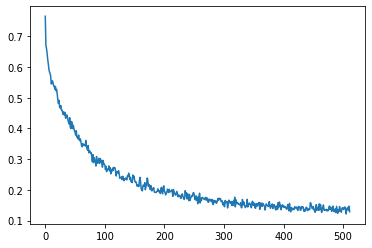

In [13]:
# Plot loss
plt.plot(tabnet_clf.history['loss'])

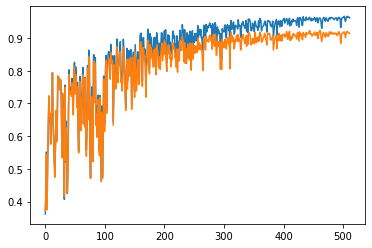

In [14]:
# Plot accuracy
plt.plot(tabnet_clf.history['train_accuracy'])
plt.plot(tabnet_clf.history['valid_accuracy'])

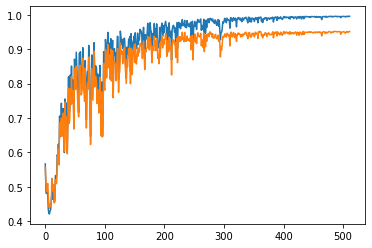

In [15]:
# Plot AUC
plt.plot(tabnet_clf.history['train_auc'])
plt.plot(tabnet_clf.history['valid_auc'])

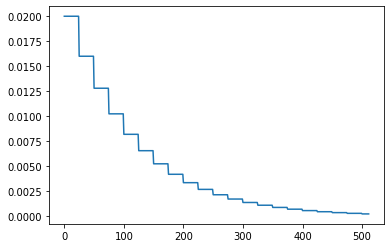

In [16]:
# Plot learning rates
plt.plot(tabnet_clf.history['lr'])

## Save and load model

In [17]:
preds = tabnet_clf.predict(X_test)
test_f1 = f1_score(y_true=y_test, y_pred=preds)

saved_filepath = 'tabnet_clf'
tabnet_clf.save_model(saved_filepath)

loaded_tabnet_clf = TabNetClassifier()
loaded_tabnet_clf.load_model(saved_filepath + '.zip')

loaded_preds = loaded_tabnet_clf.predict(X_test)
loaded_test_f1 = f1_score(y_true=y_test, y_pred=loaded_preds)

assert(test_f1 == loaded_test_f1)

Successfully saved model at tabnet_clf.zip
Device used : cuda
Device used : cuda


## Model explainability

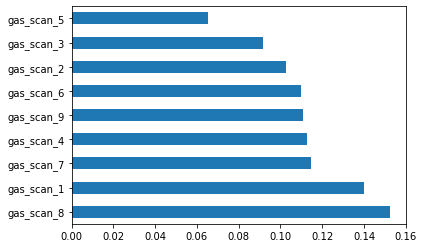

In [18]:
# Plot feature importance bar

gas_scan_features = ['gas_scan_' + str(i) for i in range(10)]
feat_importances = pd.Series(tabnet_clf.feature_importances_, index=gas_scan_features[1:])
feat_importances.nlargest(20).plot(kind='barh')